In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, callbacks, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# to not show any warnings
import warnings
warnings.filterwarnings("ignore")

# stops tensorflow's spam
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

###### Data load

In [2]:
# datasets from: https://www.kaggle.com/code/keithcooper/spam-vs-ham-neural-network/data

cols = ['Body', 'Label']

df1 = pd.read_csv('lingSpam.csv', usecols = cols)
df2 = pd.read_csv('enronSpamSubset.csv', usecols = cols)
df3 = pd.read_csv('completeSpamAssassin.csv', usecols = cols)

df = df1.append(df2).append(df3)

df.Body = df.Body.astype(str)

df.head()

,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


0 = not spam, 1 = spam

###### Separating data into training and testing sets

In [3]:
y = df.Label
X = df.Body

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# print data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (13988,)
X_test.shape: (4663,)
y_train.shape: (13988,)
y_test.shape: (4663,)


###### Data preparation

In [4]:
# split text into tokens and turn these into numbers
# 'oov' stands for out of vocabulary  and means any word not seen before

# some hyperparameters
numWords = 20000
maxLength = 200

tokenizer = Tokenizer(num_words = numWords, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding = 'post', maxlen = maxLength, truncating = 'post')

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding = 'post', maxlen = maxLength, truncating = 'post')

###### Model creation

In [5]:
# inputs should equal number of words entered into model
# output should be 1, since we only have one result/decision (spam or not spam)

model = Sequential([
    layers.Embedding(numWords, 16, input_length=maxLength),
    layers.GlobalAveragePooling1D(),
    layers.Dense(24, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           320000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 320,433
Trainable params: 320,433
Non-trainable params: 0
_________________________________________________________________


###### Running the model

In [6]:
num_epochs = 30
history = model.fit(train_padded, y_train, epochs=num_epochs, 
                    validation_data=(test_padded, y_test), verbose=2)

Epoch 1/30
438/438 - 3s - loss: 0.4235 - accuracy: 0.8176 - val_loss: 0.1654 - val_accuracy: 0.9472 - 3s/epoch - 7ms/step
Epoch 2/30
438/438 - 2s - loss: 0.1209 - accuracy: 0.9643 - val_loss: 0.0928 - val_accuracy: 0.9717 - 2s/epoch - 5ms/step
Epoch 3/30
438/438 - 2s - loss: 0.0759 - accuracy: 0.9741 - val_loss: 0.0753 - val_accuracy: 0.9732 - 2s/epoch - 5ms/step
Epoch 4/30
438/438 - 2s - loss: 0.0555 - accuracy: 0.9801 - val_loss: 0.0723 - val_accuracy: 0.9650 - 2s/epoch - 5ms/step
Epoch 5/30
438/438 - 2s - loss: 0.0440 - accuracy: 0.9831 - val_loss: 0.0634 - val_accuracy: 0.9781 - 2s/epoch - 5ms/step
Epoch 6/30
438/438 - 2s - loss: 0.0368 - accuracy: 0.9841 - val_loss: 0.0631 - val_accuracy: 0.9771 - 2s/epoch - 5ms/step
Epoch 7/30
438/438 - 2s - loss: 0.0319 - accuracy: 0.9856 - val_loss: 0.0639 - val_accuracy: 0.9768 - 2s/epoch - 5ms/step
Epoch 8/30
438/438 - 2s - loss: 0.0306 - accuracy: 0.9848 - val_loss: 0.0646 - val_accuracy: 0.9689 - 2s/epoch - 5ms/step
Epoch 9/30
438/438 - 2s 

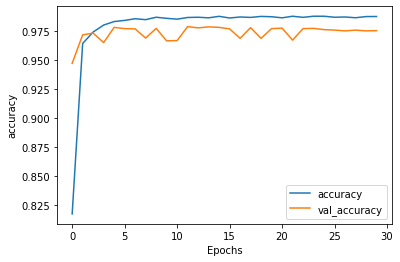

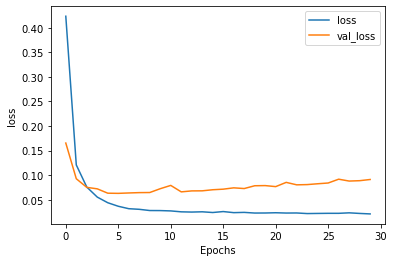

In [7]:
# summarise data in graph

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

###### Tuning the model

In [8]:
# below will stop the model from running when overfitting is detected
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    # patience means it will carry on checking for this number of epochs before it gives up and goes back to the best result
    patience=5,
    restore_best_weights=True,
)

# recreating the model, this time with 200 epochs to test early_stopping
large_num_epochs = 200
better_history = model.fit(train_padded, y_train, epochs=large_num_epochs,
                           validation_data=(test_padded, y_test), verbose=2,
                           callbacks=[early_stopping])

print('Best Model Found')

Epoch 1/200
438/438 - 2s - loss: 0.0219 - accuracy: 0.9868 - val_loss: 0.0919 - val_accuracy: 0.9747 - 2s/epoch - 5ms/step
Epoch 2/200
438/438 - 2s - loss: 0.0224 - accuracy: 0.9874 - val_loss: 0.1016 - val_accuracy: 0.9736 - 2s/epoch - 5ms/step
Epoch 3/200
438/438 - 2s - loss: 0.0226 - accuracy: 0.9870 - val_loss: 0.0961 - val_accuracy: 0.9747 - 2s/epoch - 5ms/step
Epoch 4/200
438/438 - 2s - loss: 0.0218 - accuracy: 0.9872 - val_loss: 0.0983 - val_accuracy: 0.9738 - 2s/epoch - 5ms/step
Epoch 5/200
438/438 - 2s - loss: 0.0219 - accuracy: 0.9874 - val_loss: 0.0968 - val_accuracy: 0.9745 - 2s/epoch - 5ms/step
Epoch 6/200
438/438 - 2s - loss: 0.0224 - accuracy: 0.9871 - val_loss: 0.1009 - val_accuracy: 0.9657 - 2s/epoch - 5ms/step
Best Model Found


###### Evaluating Model (metrics)

In [9]:
result = model.evaluate(test_padded, y_test)

146/146 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9747


In [10]:
# yp = y-predictor
yp = model.predict(test_padded)
yp[:100]

146/146 [==============================] - 0s 1ms/step


array([[9.99460042e-01],
       [2.08052586e-14],
       [7.28949785e-01],
       [2.00775485e-05],
       [1.76837744e-08],
       [9.04756308e-01],
       [9.99999464e-01],
       [9.99794960e-01],
       [7.57286471e-05],
       [7.71371333e-07],
       [9.88406003e-01],
       [6.48511013e-06],
       [9.99999166e-01],
       [1.00000000e+00],
       [9.99863863e-01],
       [5.69158056e-13],
       [2.40278769e-10],
       [3.63445070e-05],
       [1.15580049e-04],
       [9.99891937e-01],
       [3.96558724e-17],
       [2.12624043e-04],
       [6.71982008e-08],
       [5.94866947e-07],
       [9.99966443e-01],
       [9.94048536e-01],
       [9.99979913e-01],
       [9.99998748e-01],
       [6.81863558e-21],
       [3.47301848e-02],
       [2.68106064e-25],
       [7.86085911e-06],
       [9.99982476e-01],
       [9.68622127e-11],
       [9.99942482e-01],
       [5.48077649e-14],
       [9.99982238e-01],
       [9.99786496e-01],
       [1.47523114e-08],
       [1.47229506e-10],


In [11]:
# if value is greater than 0.5, append 1 to list (spam)
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [12]:
y_pred[:25]

[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]

In [13]:
y_test[:25]

4302    1
1512    0
34      1
5703    0
6301    0
1212    1
2508    1
4655    1
1239    0
4023    0
2358    1
5778    0
3791    1
1184    1
2514    1
6841    0
1798    0
9703    0
6333    0
3147    1
1199    0
2054    0
9359    0
4716    0
2779    1
Name: Label, dtype: int64

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2846
           1       0.96      0.98      0.97      1817

    accuracy                           0.97      4663
   macro avg       0.97      0.98      0.97      4663
weighted avg       0.98      0.97      0.97      4663



Text(69.0, 0.5, 'Truth')

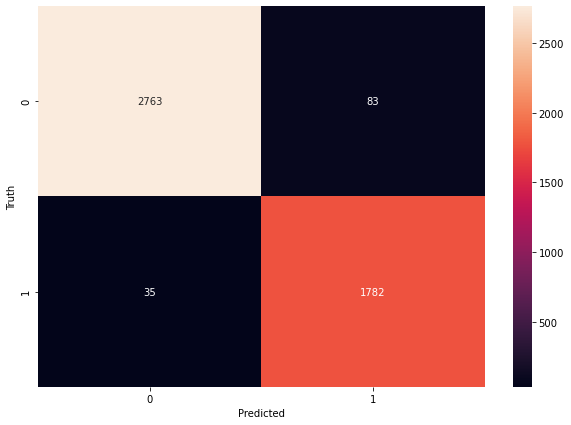

In [15]:
# cm = confusion matrix
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

###### Check model prediction (input mode)

In [16]:
# uncomment below to run manual prediction

#header = input("Enter email header: ")
#body = input("Enter email body: ")
#email = 'Subject: ' + header + '\n\n' + body

# example of spam email (comment to run manually if previous lines are uncommented)
email = 'Subject: You have won an iPhone 14 Pro Max/n/n*Click the button to redeem now!'

predict_sequences = tokenizer.texts_to_sequences([email,])
predict_padded = pad_sequences(predict_sequences, padding = 'post', maxlen = maxLength, truncating = 'post')

print('SPAM' if model.predict(predict_padded) > 0.5 else 'NOT SPAM')

1/1 [==============================] - 0s 24ms/step
SPAM
